# Overview
This notebook developes a Spam message identification model using pyspark in an AWS Sagemaker evironment. The dataset for this model is the UCI SMS Spam Collection Data Set found [here](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). While this dataset is small, the problem this notebook addresses, Spam messages, is a problem that encompasses large enough amounts of data to be a task suited for the Spark platform. 

# Import

## Packages / Libraries

In [1]:
import re
import os
import boto3
from functools import reduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import sagemaker
import sagemaker_pyspark
from sagemaker import get_execution_role

from pyspark import SparkContext, SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import Tokenizer, StopWordsRemover, \
                               HashingTF, IDF
from pyspark.ml.linalg import VectorUDT
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, DoubleType,\
                              IntegerType, StringType

from sagemaker_pyspark import RandomNamePolicyFactory, IAMRole,\
                              EndpointCreationPolicy, SageMakerModel,\
                              SageMakerResourceCleanup
from sagemaker_pyspark.algorithms import XGBoostSageMakerEstimator, PCASageMakerEstimator
from sagemaker_pyspark.transformation.serializers \
     import ProtobufRequestRowSerializer
from sagemaker_pyspark.transformation.serializers.serializers \
     import LibSVMRequestRowSerializer

from sklearn.metrics import confusion_matrix

#Set Seed for Random Actions
seed = 5590

## Setup AWS and Spark
The following code blocks set up the global values and settings for AWS and Spark parameters.

### AWS

In [2]:
role = get_execution_role()
bucket = "dsba-6190-project3-spark"
file_name = "spam.csv"
session = sagemaker.Session()
region = boto3.Session().region_name

### Spark

In [3]:
# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github to learn how to connect to EMR from a notebook instance
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local")\
    .appName("Spam Filter")\
    .getOrCreate()
    
spark

## Load Data
When we try to load the data using default settings, the import adds headers and includes several empty columns. To avoid this, we define the schema of the data before we import.

In [4]:
# Define Known Schema
schema = StructType([
    StructField("class", StringType()),
    StructField("sms", StringType())
])

# Import CSV
df = spark.read\
          .schema(schema)\
          .option("header", "true")\
          .csv('s3a://{}/{}'.format(bucket, file_name))

df_num_col =  len(df.columns)
df_num_rows = df.count()

# Inspect Import
df.show(5)
print()
print("Schema")
df.printSchema()
print()
print("Shape - Rows x Columns")
print(df_num_rows,"x", df_num_col)

+-----+--------------------+
|class|                 sms|
+-----+--------------------+
|  ham|Go until jurong p...|
|  ham|Ok lar... Joking ...|
| spam|Free entry in 2 a...|
|  ham|U dun say so earl...|
|  ham|Nah I don't think...|
+-----+--------------------+
only showing top 5 rows


Schema
root
 |-- class: string (nullable = true)
 |-- sms: string (nullable = true)


Shape - Rows x Columns
5574 x 2


#### Check Null Values
We need to check and see if our data contains any null values. 

In [5]:
df.where(reduce(lambda x, y: x | y, (f.col(x).isNull() for x in df.columns))).show()

+------+----+
| class| sms|
+------+----+
|ham"""|null|
+------+----+



It appears one of the rows contains null values, and the class label is corrupted as well. We can go ahead and drop this row.

In [6]:
df = df.dropna()

Lets now inspect the dataframe now that the null row has been dropped.

In [7]:
df_num_col =  len(df.columns)
df_num_rows = df.count()

# Inspect Import
df.show(5)
print()
print("Schema")
df.printSchema()
print()
print("Shape - Rows x Columns")
print(df_num_rows,"x", df_num_col)

+-----+--------------------+
|class|                 sms|
+-----+--------------------+
|  ham|Go until jurong p...|
|  ham|Ok lar... Joking ...|
| spam|Free entry in 2 a...|
|  ham|U dun say so earl...|
|  ham|Nah I don't think...|
+-----+--------------------+
only showing top 5 rows


Schema
root
 |-- class: string (nullable = true)
 |-- sms: string (nullable = true)


Shape - Rows x Columns
5573 x 2


Re-check null values.

In [8]:
df.where(reduce(lambda x, y: x | y, (f.col(x).isNull() for x in df.columns))).show()

+-----+---+
|class|sms|
+-----+---+
+-----+---+



# EDA
We'll do some very basic EDA here. First we'll look at the breakdown of our target variables. 

In [9]:
df.groupBy("class").count().show()

+------+-----+
| class|count|
+------+-----+
|ham"""|    1|
|   ham| 4825|
|  spam|  747|
+------+-----+



Clearly there is an error with the class label on one value. Lets see what the message is associated with **ham"""**.

In [10]:
df.where(f.col("class") == 'ham"""').show(truncate = False)

+------+---------------------------------------------------------+
|class |sms                                                      |
+------+---------------------------------------------------------+
|ham"""|Well there's still a bit left if you guys want to tonight|
+------+---------------------------------------------------------+



This doesn't seem out of the oridinary, and appears to be a **ham** sms message. I am going to change **ham"""** to **ham**.

In [11]:
df = df.withColumn("class", f.when(f.col("class") == 'ham"""' , 'ham').
                     otherwise(f.col("class")))

Lets verify the change occurred.

In [12]:
df.groupBy("class").count().show()

+-----+-----+
|class|count|
+-----+-----+
|  ham| 4826|
| spam|  747|
+-----+-----+



# Preprocess
Before we perform any analysis on the data we will need to perform two major steps:

1. Text Normalization
2. Tokenization 

With Text Normalization, we will process the raw text to provide a quality input for our model. These actions used the blog post [**Spam classification using Spark’s DataFrames, ML and Zeppelin (Part 1)**](https://blog.codecentric.de/en/2016/06/spam-classification-using-sparks-dataframes-ml-zeppelin-part-1/) by Daniel Pape, accessed on 4/16/2020, as guidance for some of these actions. This blog post provided a good framework particularly for handling types of text you find in an SMS message, such as emoticons.

Once the raw text is normalized, we can then tokenize and convert the text into a form that can be used by the analytical model.

## Text Normalization
To normalize the text, there are several steps we plan on taking:

1. Convert all text to lowercase
2. Convert all numbers to the text **_" normalized_number "_**
3. Convert all emoticons to the text **_" normalized_emoticon "_**
4. Convert all currency symbols to the text **_" normalized_currency_symbol "_**
5. Convert all links to the text **_" normalized_url "_**
6. Convert all email addresses to the text **_" normalized_email "_**
7. Convert all diamond/question mark symbols to the text **_" normalized_doamond_symbol "_**
8. Remove HTML characters
9. Remove punctuation

### Convert Text to Lower Case

In [13]:
df_norm = df.select("class","sms", f.lower(f.col("sms")).alias("sms_norm"))
df_norm.show(5)

+-----+--------------------+--------------------+
|class|                 sms|            sms_norm|
+-----+--------------------+--------------------+
|  ham|Go until jurong p...|go until jurong p...|
|  ham|Ok lar... Joking ...|ok lar... joking ...|
| spam|Free entry in 2 a...|free entry in 2 a...|
|  ham|U dun say so earl...|u dun say so earl...|
|  ham|Nah I don't think...|nah i don't think...|
+-----+--------------------+--------------------+
only showing top 5 rows



### Normalize Symbols and Objects
To normalize the symbols and objects in the data, we will need to define user functions and employ replacement with regex tools.

To enable a method to cycle through the dataframe and make all the necessary replacements, I am going to define a dictionary, where each key is the expression that will be used to find what needs to be replaces, and the value is the repalcement string.

The regex for the emoticons came from [here](https://www.regextester.com/96995).

The remaining regex expressions came from [here](https://github.com/daniel-pape/spark-logistic-regression-spam-sms/blob/master/src/main/scala/preprocessing/LineCleaner.scala)

In [14]:
html_list = ["&lt;", "&gt;", "&amp;", "&cent;", "&pound;", "&yen;", "&euro;", "&copy;", "&reg;"]

In [15]:
regex_url = "\\w+(\\.|-)*\\w+@.*\\.(com|de|uk)"
regex_emoticon = ":\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\)"
regex_number = "\\d+"
regex_punctuation ="[\\.\\,\\:\\-\\!\\?\\n\\t,\\%\\#\\*\\|\\=\\(\\)\\\"\\>\\<\\/]"
regex_currency = "[\\$\\€\\£]"
regex_url =  "(http://|https://)?www\\.\\w+?\\.(de|com|co.uk)"
regex_diamond_question = "�"
regex_html = "|".join(html_list)

dict_norm = {
    regex_emoticon : " normalized_emoticon ",
    regex_url : " normalized_emailadress ",
    regex_number : " normalized_number ",
    regex_punctuation : " ",
    regex_currency : " normalized_currency_symbol ",
    regex_url: " normalized_url ",
    regex_diamond_question : " normalized_doamond_symbol ",
    regex_html : " "
}

#dict_norm

In [16]:
for key, value in dict_norm.items():
    df_norm = df_norm.withColumn("sms_norm", f.regexp_replace(f.col("sms_norm"),key, value))

In [17]:
df_norm.select('sms_norm').show(5, truncate = False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sms_norm                                                                                                                                                                                                                                            |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|go until jurong point  crazy   available only in bugis n great world la e buffet    cine there got amore wat                                                                                                                                        |
|ok lar    j

In [18]:
df = df_norm.dropna()

print("Shape - Rows x Columns")
print(df.count(),"x", len(df.columns))

Shape - Rows x Columns
5573 x 3


We're going to check again for null values, to ensure the conversion hasn't created any new null values.

In [19]:
df = df_norm
df.where(reduce(lambda x, y: x | y, (f.col(x).isNull() for x in df.columns))).show()

+-----+---+--------+
|class|sms|sms_norm|
+-----+---+--------+
+-----+---+--------+



## Convert Class to Binary
We need to convert our spam/ham class to a binary. We also need to conert the column type to int.

In [20]:
df_norm = df_norm.withColumn("class", f.when(f.col("class") == "spam" , 1).
                             when(f.col("class") == "ham" , 0).
                             otherwise(f.col("class")))

df_norm.show(5)

+-----+--------------------+--------------------+
|class|                 sms|            sms_norm|
+-----+--------------------+--------------------+
|    0|Go until jurong p...|go until jurong p...|
|    0|Ok lar... Joking ...|ok lar    joking ...|
|    1|Free entry in 2 a...|free entry in  no...|
|    0|U dun say so earl...|u dun say so earl...|
|    0|Nah I don't think...|nah i don't think...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [21]:
df_norm.printSchema()

root
 |-- class: string (nullable = true)
 |-- sms: string (nullable = true)
 |-- sms_norm: string (nullable = true)



In [22]:
df_norm = df_norm.withColumn("class", f.col('class').cast(IntegerType()))
df_norm.show(5)
df_norm.printSchema()

+-----+--------------------+--------------------+
|class|                 sms|            sms_norm|
+-----+--------------------+--------------------+
|    0|Go until jurong p...|go until jurong p...|
|    0|Ok lar... Joking ...|ok lar    joking ...|
|    1|Free entry in 2 a...|free entry in  no...|
|    0|U dun say so earl...|u dun say so earl...|
|    0|Nah I don't think...|nah i don't think...|
+-----+--------------------+--------------------+
only showing top 5 rows

root
 |-- class: integer (nullable = true)
 |-- sms: string (nullable = true)
 |-- sms_norm: string (nullable = true)



## Text Tokenization
We will tokenize the text using a pyspark pipeline. First, we must initialize the pipeline components. For this pipeline, we will user the following estimators:

1. Tokenizer
2. Stop Words Remover
3. Term Frequency Hashing

### Establish Pipeline

In [23]:
tokenizer = Tokenizer(inputCol="sms_norm", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="tokens_filtered")
hashingTF = HashingTF(inputCol="tokens", outputCol="features_tf", numFeatures=1000)

pipeline_text = Pipeline(stages=[tokenizer, remover, hashingTF])

### Execute Pipeline on Complete Dataset

In [24]:
pipeline_text_fit = pipeline_text.fit(df_norm)
df_pipeline = pipeline_text_fit.transform(df_norm)
df_pipeline.show(20)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|class|                 sms|            sms_norm|              tokens|     tokens_filtered|         features_tf|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|Go until jurong p...|go until jurong p...|[go, until, juron...|[go, jurong, poin...|(1000,[7,77,150,1...|
|    0|Ok lar... Joking ...|ok lar    joking ...|[ok, lar, , , , j...|[ok, lar, , , , j...|(1000,[20,372,484...|
|    1|Free entry in 2 a...|free entry in  no...|[free, entry, in,...|[free, entry, , n...|(1000,[35,73,128,...|
|    0|U dun say so earl...|u dun say so earl...|[u, dun, say, so,...|[u, dun, say, ear...|(1000,[57,368,372...|
|    0|Nah I don't think...|nah i don't think...|[nah, i, don't, t...|[nah, think, goes...|(1000,[135,210,32...|
|    1|FreeMsg Hey there...|freemsg hey there...|[freemsg, hey, th...|[freemsg, hey, da...|(1000

## Train / Test Split
Now that we have performed all the possible actions that should be performed on the complete dataset, we split the data into train/test.

In [25]:
split_train = 0.8
train, test = df_pipeline.randomSplit([split_train, (1-split_train)], seed=seed)

### Verify Split

In [26]:
print("Shape - Train")
print((train.count(), len(train.columns)))
print()
print("Shape - Test")
print((test.count(), len(test.columns)))

Shape - Train
(4423, 6)

Shape - Test
(1150, 6)


## Inverse Document Frequency Calculation
To calculate the Term Frequency - Inverse Document Frequency values for the corpus, we need to train the IDF estmator on the **train** data. Then we apply the trained estimator to the train and test set. 

In [27]:
#Initialize IDF Estimator
idf = IDF(minDocFreq=2, inputCol="features_tf", outputCol="features_tfidf")

# Train IDF Estimator to Term Frequency Data
idfModel = idf.fit(train)

# Re-Scale Term Frequency Data to 
train = idfModel.transform(train)
test = idfModel.transform(test)

In [28]:
train.show(10)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|class|                 sms|            sms_norm|              tokens|     tokens_filtered|         features_tf|      features_tfidf|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0| &lt;#&gt;  in mc...|      in mca  but...|[, , , , , , in, ...|[, , , , , , mca,...|(1000,[18,83,372,...|(1000,[18,83,372,...|
|    0| &lt;DECIMAL&gt; ...|  decimal  m but ...|[, , decimal, , m...|[, , decimal, , m...|(1000,[18,62,83,1...|(1000,[18,62,83,1...|
|    0| and  picking the...| and  picking the...|[, and, , picking...|[, , picking, var...|(1000,[128,263,33...|(1000,[128,263,33...|
|    0| came to look at ...| came to look at ...|[, came, to, look...|[, came, look, fl...|(1000,[7,146,197,...|(1000,[7,146,197,...|
|    0| gonna let me kno...| gonna let me kno...|[, gonna, let

In [29]:
test.show(10)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|class|                 sms|            sms_norm|              tokens|     tokens_filtered|         features_tf|      features_tfidf|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0| &lt;#&gt;  mins ...|      mins but i ...|[, , , , , , mins...|[, , , , , , mins...|(1000,[73,83,183,...|(1000,[73,83,183,...|
|    0|"7 wonders in My ...|  normalized_numb...|[, , normalized_n...|[, , normalized_n...|(1000,[19,104,150...|(1000,[19,104,150...|
|    0|"A Boy loved a ga...| a boy loved a ga...|[, a, boy, loved,...|[, boy, loved, ga...|(1000,[24,29,62,6...|(1000,[24,29,62,6...|
|    0|"Awesome question...| awesome question...|[, awesome, quest...|[, awesome, quest...|(1000,[19,122,159...|(1000,[19,122,159...|
|    0|"Cool breeze... B...| cool breeze    b...|[, cool, bree

## Isolate Data
Moving forward we only need the tf-idf features and the class label. We will relabel them features and label to be consistent with the XGBoost Estmator input labels.

In [30]:
# Select Data
df_train = train.select(f.col("class").alias("label"), f.col("features_tfidf").alias("features"))
df_train.show(5)
df_train.printSchema()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(1000,[18,83,372,...|
|    0|(1000,[18,62,83,1...|
|    0|(1000,[128,263,33...|
|    0|(1000,[7,146,197,...|
|    0|(1000,[51,134,164...|
+-----+--------------------+
only showing top 5 rows

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



In [31]:
df_test = test.select(f.col("class").alias("label"), f.col("features_tfidf").alias("features"))
df_test.show(5)
df_test.printSchema()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(1000,[73,83,183,...|
|    0|(1000,[19,104,150...|
|    0|(1000,[24,29,62,6...|
|    0|(1000,[19,122,159...|
|    0|(1000,[170,196,29...|
+-----+--------------------+
only showing top 5 rows

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



# Train
We will be training our data on the Sagemaker Pyspark XGBoost algorithm. One tricky part about using this algorithm is that it only takes **LIBSVM** format data. Unfortunatley, that is not the current format of our data. In order for the algoritm to accept our data as an input, we need to do three things

1. Define the correct shema
2. Convert data to match the correct schema
3. Include **LibSVMRequestRowSerializer** as a parameter when initializing the XGBoost estimator.

## Define the Schema
In order to be accepted as a **LIBSVM** type data, the schema of our pyspark DataFrame must be a specific schema. The schema can be seen buried in the source code of the **Verify Schema** call in the **LibSVMRelation.scala** utility, see [here](https://github.com/apache/spark/blob/930b90a84871e2504b57ed50efa7b8bb52d3ba44/mllib/src/main/scala/org/apache/spark/ml/source/libsvm/LibSVMRelation.scala#L79) (accessed 4/17/2020). Based on this function, our data needs to be in two columns, one column a **DoubleType()** (which will be our label column) and the other column a **VectorUDT()** type (which will be our Sparse Vector features column). 

With these requirements, we define a general schema.

In [32]:
schema = StructType([
    StructField("label", DoubleType()),
    StructField("features", VectorUDT())
])

print(schema)

StructType(List(StructField(label,DoubleType,true),StructField(features,VectorUDT,true)))


## Convert Data to Match Schema
We also convert the data types of our current train and test data sets to match this data type.

In [33]:
#Train
df_train = df_train.withColumn("label", f.col('label').cast(DoubleType()))
df_train = df_train.withColumn("features", f.col('features').cast(VectorUDT()))
print("Schema - Train")
df_train.printSchema()
print()

# Test
df_test = df_test.withColumn("label", f.col('label').cast(DoubleType()))
df_test = df_test.withColumn("features", f.col('features').cast(VectorUDT()))
print("Schema - Test")
df_test.printSchema()

Schema - Train
root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)


Schema - Test
root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



## Initialize Model
We will now initialize the XGBoost Estimator. A few notes:

* In order for the estimator to accept our input data as **LIBSVM**, we need to use the parameter **requestRowSerializer**. We define this parameter as **LibSVMRequestRowSerializer**, identifying the feature column, label column, and schema. 
* This is personal preference, but I like adding name to the mode we're creating. It makes it easier to find when you're looking up past trained models. So we add a **namPolicyFactory** value. But be careful. If you want to deploy your model as an endpoint, the maximum number of characters the model name can have is 63. This means the prefix you add to the front of your model can only be about 10 characters. Sagemaker will tack-on the rest of the model tag. If you exceed 63 characters, deploying your endpoint will fail.

In [34]:
xgboost_estimator = XGBoostSageMakerEstimator(
  sagemakerRole = IAMRole(role),
  requestRowSerializer = LibSVMRequestRowSerializer(schema=schema,
                                                    featuresColumnName="features",
                                                    labelColumnName="label"),
  trainingInstanceType = "ml.m4.xlarge",
  trainingInstanceCount = 1,
  endpointInstanceType = "ml.m4.xlarge",
  endpointInitialInstanceCount = 1,
  namePolicyFactory=RandomNamePolicyFactory("spam-xgb-"),
  endpointCreationPolicy = EndpointCreationPolicy.CREATE_ON_TRANSFORM
)

## Set Hyperparameters
After initializing the model, we set the hyperparameters. This problem is a binary classification problem, so we'll et the objective to **binary:logistic** and evaluate based on the **AUC** score.

In [35]:
xgboost_estimator.setNumRound(15)
xgboost_estimator.setObjective("binary:logistic")
xgboost_estimator.setEvalMetric("auc")
xgboost_estimator.setSeed(seed)

## Train
With everything set, we can now train the mode.

In [36]:
model = xgboost_estimator.fit(df_train)

# Evaluate
## Transform
First, we generate predictons based off the test set.

In [37]:
predictions = model.transform(df_test)

Then, we will assign predicted labels, using 0.5 as a threshold.

We will also create re-labeled columns with spam and ham. This will be primarily for downstream visuals.

In [38]:
predictions = predictions.withColumn("prediction_binary", f.when(f.col("prediction") > 0.5 , 1.0).otherwise(0.0))
predictions = predictions.withColumn("prediction_spam", f.when(f.col("prediction_binary") == 1 , "spam").otherwise("ham"))
predictions = predictions.withColumn("label_spam", f.when(f.col("label") == 1 , "spam").otherwise("ham"))
predictions.show(5)

+-----+--------------------+----------------+-----------------+---------------+----------+
|label|            features|      prediction|prediction_binary|prediction_spam|label_spam|
+-----+--------------------+----------------+-----------------+---------------+----------+
|  0.0|(1000,[73,83,183,...| 0.0203639212996|              0.0|            ham|       ham|
|  0.0|(1000,[19,104,150...| 0.0507496446371|              0.0|            ham|       ham|
|  0.0|(1000,[24,29,62,6...| 0.0954567715526|              0.0|            ham|       ham|
|  0.0|(1000,[19,122,159...| 0.0118381446227|              0.0|            ham|       ham|
|  0.0|(1000,[170,196,29...|0.00729368859902|              0.0|            ham|       ham|
+-----+--------------------+----------------+-----------------+---------------+----------+
only showing top 5 rows



Lets take a look at the predicted distribution.

In [39]:
predictions.groupBy("prediction_spam").count().show()

+---------------+-----+
|prediction_spam|count|
+---------------+-----+
|            ham| 1013|
|           spam|  137|
+---------------+-----+



### Scores
Now we can look at some of the classification scores. Note that we are using both the **MulticlassClassificationEvaluator** and **BinaryClassificationEvaluator** objects to generate the metrics we want. 

In [40]:
def output_scores(predictions):
    ### Multi-Class Evaluator
    dict_metric_multi = {"Accuracy" : "accuracy", 
                         "Precision - Weighted": "weightedPrecision", 
                         "F1 Score": "f1"}

    for key, value in dict_metric_multi.items():
        evaluator =  MulticlassClassificationEvaluator(labelCol="label", 
                                                   predictionCol=\
                                                       "prediction_binary", 
                                                   metricName=value)

        metric = evaluator.evaluate(predictions)

        print(key + ": {:.3f}".format(metric))   
    
    # Binary Class Evaluator
    dict_metric_bin = {"AUC Score" : "areaUnderROC"}
    for key, value in dict_metric_bin.items():
    
        evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", 
                                                  labelCol="label", 
                                                  metricName=value)
        
        metric = evaluator.evaluate(predictions)
        print(key + ": {:.3f}".format(metric))

In [41]:
output_scores(predictions)

Accuracy: 0.980
Precision - Weighted: 0.980
F1 Score: 0.980
AUC Score: 0.977


## Confusion Matrix
We are going to visualize the confusion matrix using the method outlined [here](https://runawayhorse001.github.io/LearningApacheSpark/classification.html#demo).
### Confusion Matrix Plotting Function

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print()
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Define Class Names

In [43]:
# Create List of Class Names
class_label = predictions.select("label_spam").groupBy("label_spam")\
    .count().sort('count', ascending=False).toPandas()
class_names = class_label["label_spam"].to_list()
class_names
#class_names = list(map(str, class_names))

['ham', 'spam']

### Generate Raw Confusion Matrix

In [44]:
# Convert Labels to Pandas Dataframe
y_true = predictions.select("label_spam")
y_true = y_true.toPandas()

# Convert Predictions to Pandas Dataframe
y_pred = predictions.select("prediction_spam")
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_true, y_pred, labels=class_names)

### Plot

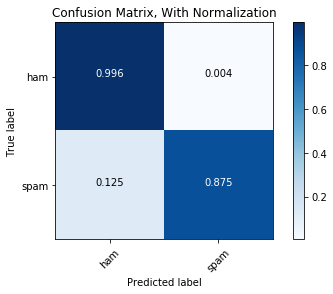

In [45]:
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names,
                      normalize=True,
                      title='Confusion Matrix, With Normalization')
plt.show()

# Clean-Up
After everything is done, we do not wan't to leave resources needlessly running, costing us money. So, we shut everything down.

In [46]:
resource_cleanup = SageMakerResourceCleanup(model.sagemakerClient)
resource_cleanup.deleteResources(model.getCreatedResources())